In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sae_lens import SAE

/cs/student/projects2/aisd/2024/seongcho/miniconda3/envs/sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
llm = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
llm.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
from convert import convert

In [6]:
tinystories, _ = convert('checkpoints/gpt2-small_blocks.8.hook_resid_pre_12288_topk_16_0.0003_42_TinyStories_24413/')

/cs/student/projects2/aisd/2024/seongcho/sparse_autoencoder/BatchTopK/convert.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original.load_state_dict(torch.load(join(f

In [7]:
openwebtext, _ = convert('checkpoints/gpt2-small_blocks.8.hook_resid_pre_12288_topk_16_0.0003_244139/')

In [8]:
target_feature = 6

print(torch.nn.functional.cosine_similarity(openwebtext.W_dec, tinystories.W_dec[target_feature, :], dim=1).max())
print(torch.nn.functional.cosine_similarity(openwebtext.W_dec, tinystories.W_dec[target_feature, :], dim=1).topk(5))
print(torch.nn.functional.cosine_similarity(openwebtext.W_dec, tinystories.W_dec[target_feature, :], dim=1).argmax())
print(torch.nn.functional.cosine_similarity(openwebtext.W_dec[target_feature, :], tinystories.W_dec[target_feature, :], dim=0))

tensor(0.7465, device='cuda:0', grad_fn=<MaxBackward1>)
torch.return_types.topk(
values=tensor([0.7465, 0.4833, 0.4774, 0.4468, 0.4042], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([9044, 6495, 4206, 3952, 9630], device='cuda:0'))
tensor(9044, device='cuda:0')
tensor(-0.0581, device='cuda:0', grad_fn=<SumBackward1>)


In [142]:
from tqdm import tqdm
import pandas as pd

# For each decoder column vs. all encoder columns
neuron_sim = []
feature_sim = []

for i in tqdm(range(openwebtext.W_enc.shape[1])):
    maximal = torch.nn.functional.cosine_similarity(openwebtext.W_dec, tinystories.W_dec[i, :], dim=1).topk(4)
    feature_sim.append(maximal.values.detach().cpu())
for i in tqdm(range(openwebtext.W_enc.shape[0])):
    maximal = torch.nn.functional.cosine_similarity(openwebtext.W_dec.T, tinystories.W_dec[:, i], dim=1).topk(4)
    neuron_sim.append(maximal.values.detach().cpu())

dec_neuron_sim_ds = pd.DataFrame(torch.stack(neuron_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])
dec_feature_sim_ds = pd.DataFrame(torch.stack(feature_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])

  0%|          | 0/12288 [00:00<?, ?it/s]

100%|██████████| 768/768 [00:00<00:00, 1884.63it/s]


In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

def visualize_distribution(data, title, xlabel, ylabel='Activation', color='blue', plot_type='line', log_scale=False, monoton=False, size=20, palette='flare', bins=100, legends = []):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(data))
    cmap = sns.color_palette(palette, as_cmap=True)
    
    if plot_type == 'line':
        colors = np.linspace(0, 1, len(data))
        plt.plot(x, data, color='grey', linewidth=1, alpha=0.5)
        plt.scatter(x, data, c=colors, cmap=cmap, s=size)
        
    elif plot_type == 'histogram':
        ax = sns.histplot(data, bins=bins, kde=True, color=color, fill=True)
        for patch in ax.patches:
            patch.set_edgecolor("none")
        
    elif plot_type == 'scatter':
        colors = np.linspace(0, 1, len(data))
        if monoton:
            colors = sns.color_palette(palette)[0]
            plt.scatter(x, data, color=colors, s=size)
        else:
            plt.scatter(x, data, c=colors, cmap=cmap, s=size)
        
    else:
        raise ValueError("Invalid plot_type. Choose 'line', 'histogram', or 'scatter'.")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if log_scale:
        plt.yscale('log')
        
    plt.grid(False)
    plt.show()

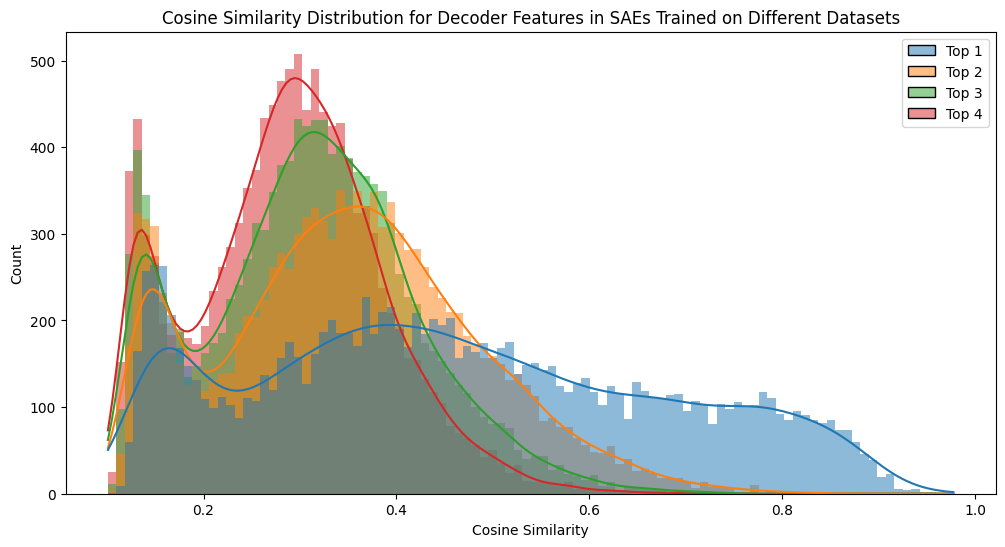

In [144]:
visualize_distribution(dec_feature_sim_ds, 'Cosine Similarity Distribution for Decoder Features in SAEs Trained on Different Datasets', 'Cosine Similarity', 'Count', plot_type='histogram', legends=['Top 1', 'Top 2', 'Top 3', 'Top 4'], palette='icefire')

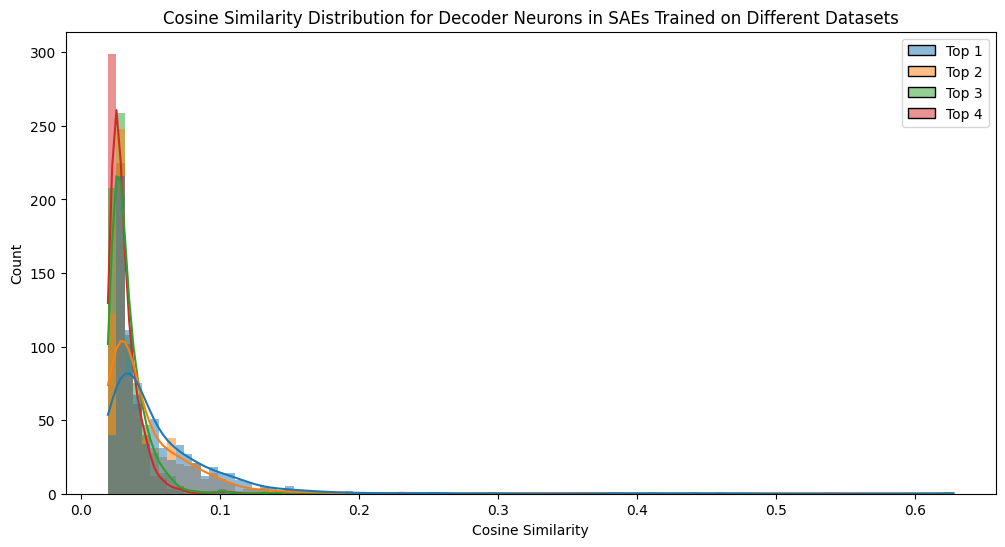

In [145]:
visualize_distribution(dec_neuron_sim_ds, 'Cosine Similarity Distribution for Decoder Neurons in SAEs Trained on Different Datasets', 'Cosine Similarity', 'Count', plot_type='histogram')

In [146]:
from tqdm import tqdm

# For each decoder column vs. all encoder columns
neuron_sim = []
feature_sim = []

for i in tqdm(range(openwebtext.W_enc.shape[1])):
    maximal = torch.nn.functional.cosine_similarity(openwebtext.W_enc.T, tinystories.W_enc.T[i, :], dim=1).topk(4)
    feature_sim.append(maximal.values.detach().cpu())
for i in tqdm(range(openwebtext.W_enc.shape[0])):
    maximal = torch.nn.functional.cosine_similarity(openwebtext.W_enc, tinystories.W_enc.T[:, i], dim=1).topk(4)
    neuron_sim.append(maximal.values.detach().cpu())

enc_neuron_sim_ds = pd.DataFrame(torch.stack(neuron_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])
enc_feature_sim_ds = pd.DataFrame(torch.stack(feature_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])

  0%|          | 0/12288 [00:00<?, ?it/s]

100%|██████████| 768/768 [00:00<00:00, 2452.25it/s]


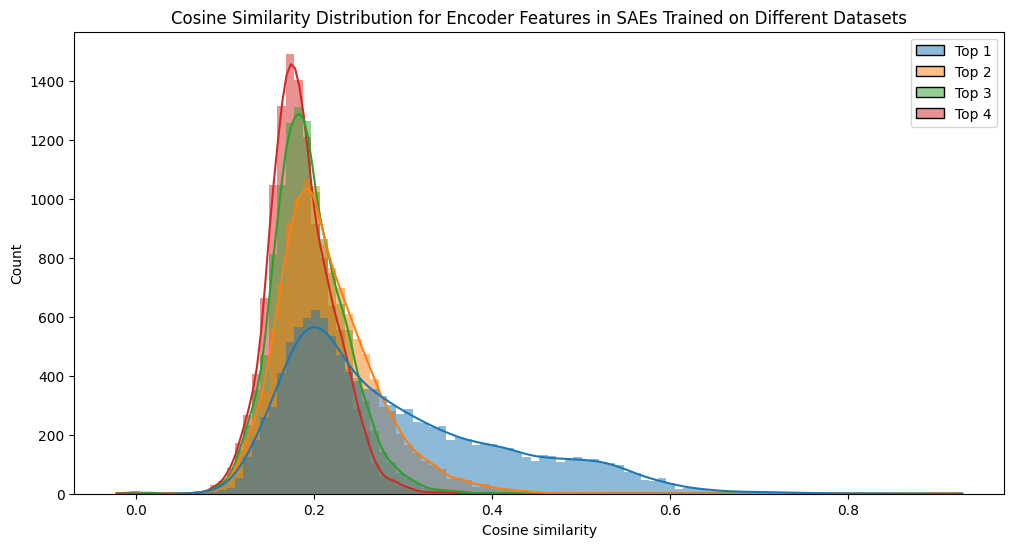

In [147]:
visualize_distribution(enc_feature_sim_ds, 'Cosine Similarity Distribution for Encoder Features in SAEs Trained on Different Datasets', 'Cosine similarity', 'Count', plot_type='histogram')

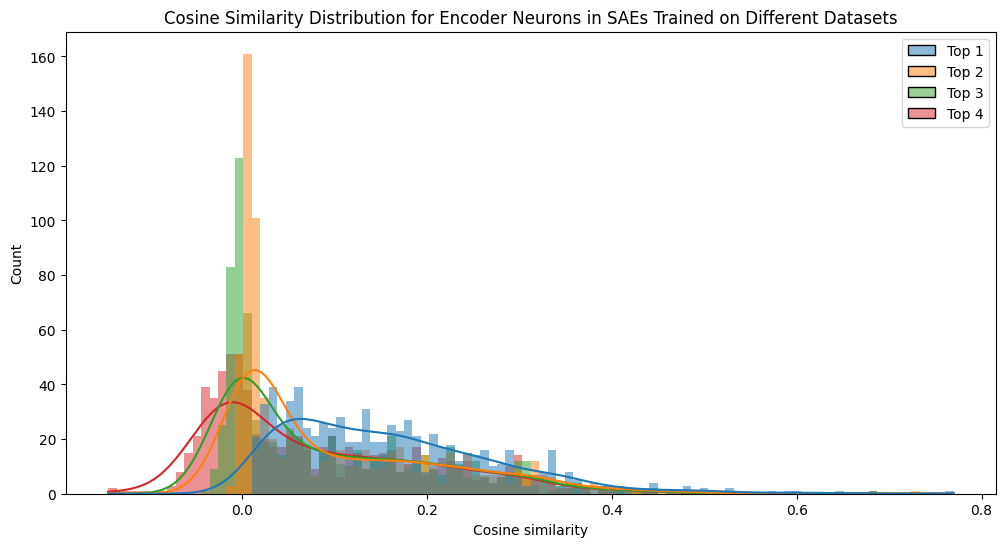

In [148]:
visualize_distribution(enc_neuron_sim_ds, 'Cosine Similarity Distribution for Encoder Neurons in SAEs Trained on Different Datasets', 'Cosine similarity', 'Count', plot_type='histogram')

In [149]:
tinystories42, _ = convert('checkpoints/gpt2-small_blocks.8.hook_resid_pre_12288_topk_16_0.0003_42_TinyStories_24413/')

/cs/student/projects2/aisd/2024/seongcho/sparse_autoencoder/BatchTopK/convert.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original.load_state_dict(torch.load(join(f

In [150]:
tinystories49, _ = convert('checkpoints/gpt2-small_blocks.8.hook_resid_pre_12288_topk_16_0.0003_49_TinyStories_24413/')

In [151]:
from tqdm import tqdm

# For each decoder column vs. all encoder columns
neuron_sim = []
feature_sim = []

for i in tqdm(range(tinystories42.W_enc.shape[1])):
    maximal = torch.nn.functional.cosine_similarity(tinystories42.W_dec, tinystories49.W_dec[i, :], dim=1).topk(4)
    feature_sim.append(maximal.values.detach().cpu())
for i in tqdm(range(tinystories42.W_enc.shape[0])):
    maximal = torch.nn.functional.cosine_similarity(tinystories42.W_dec.T, tinystories49.W_dec[:, i], dim=1).topk(4)
    neuron_sim.append(maximal.values.detach().cpu())

dec_neuron_sim_seed = pd.DataFrame(torch.stack(neuron_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])
dec_feature_sim_seed = pd.DataFrame(torch.stack(feature_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])

  0%|          | 0/12288 [00:00<?, ?it/s]

100%|██████████| 768/768 [00:00<00:00, 1888.56it/s]


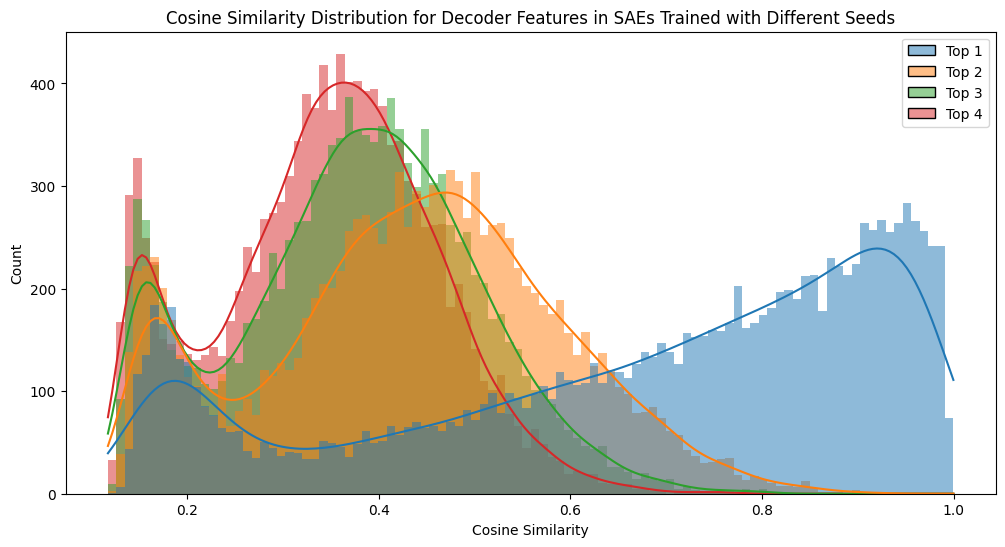

In [152]:
visualize_distribution(dec_feature_sim_seed, 'Cosine Similarity Distribution for Decoder Features in SAEs Trained with Different Seeds', 'Cosine Similarity', 'Count', plot_type='histogram')

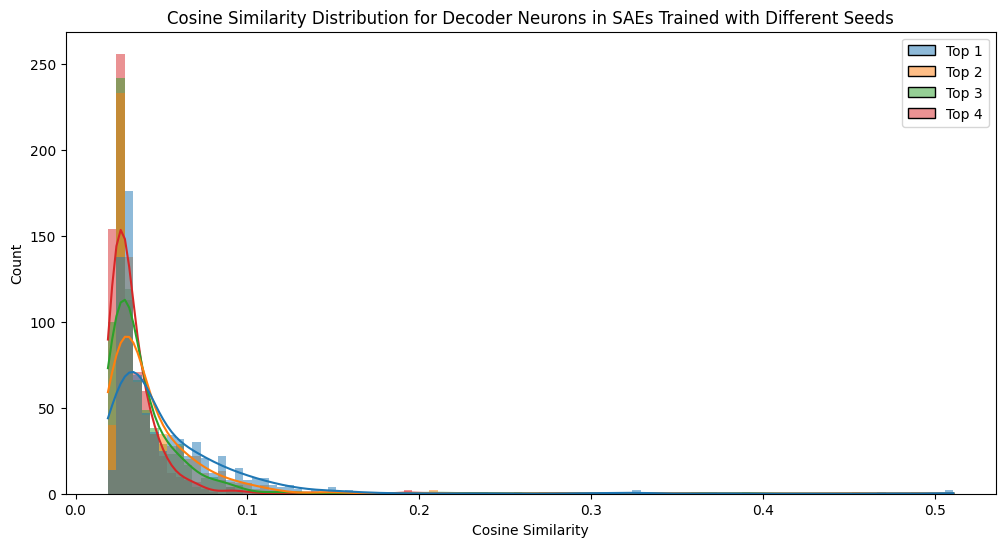

In [153]:
visualize_distribution(dec_neuron_sim_seed, 'Cosine Similarity Distribution for Decoder Neurons in SAEs Trained with Different Seeds', 'Cosine Similarity', 'Count', plot_type='histogram')

In [154]:
from tqdm import tqdm

# For each decoder column vs. all encoder columns
neuron_sim = []
feature_sim = []

for i in tqdm(range(tinystories42.W_enc.shape[1])):
    maximal = torch.nn.functional.cosine_similarity(tinystories42.W_enc.T, tinystories49.W_enc.T[i, :], dim=1).topk(4)
    feature_sim.append(maximal.values.detach().cpu())
for i in tqdm(range(tinystories42.W_enc.shape[0])):
    maximal = torch.nn.functional.cosine_similarity(tinystories42.W_enc, tinystories49.W_enc.T[:, i], dim=1).topk(4)
    neuron_sim.append(maximal.values.detach().cpu())

enc_neuron_sim_seed = pd.DataFrame(torch.stack(neuron_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])
enc_feature_sim_seed = pd.DataFrame(torch.stack(feature_sim).numpy(), columns=["Top 1", "Top 2", "Top 3", "Top 4"])

  0%|          | 0/12288 [00:00<?, ?it/s]

100%|██████████| 768/768 [00:00<00:00, 2435.81it/s]


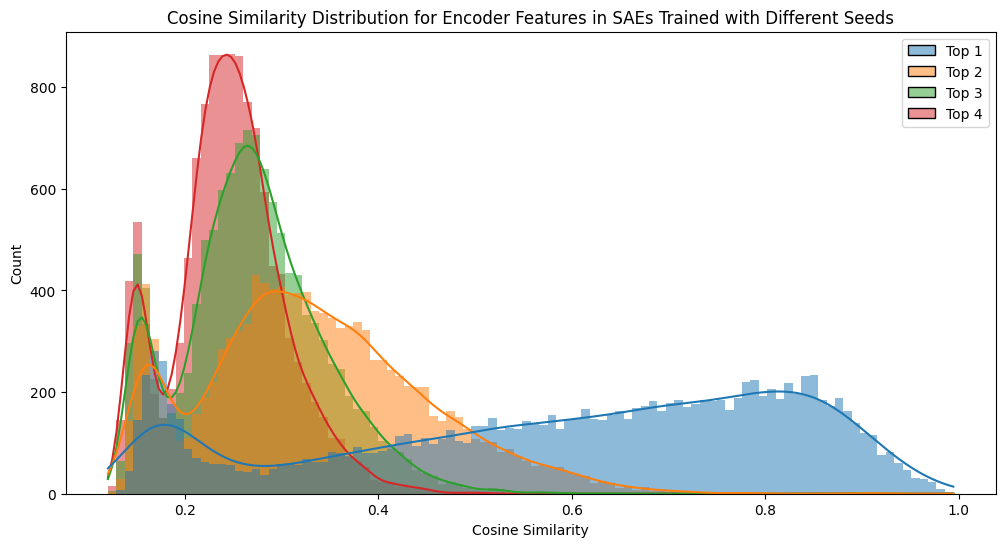

In [155]:
visualize_distribution(enc_feature_sim_seed, 'Cosine Similarity Distribution for Encoder Features in SAEs Trained with Different Seeds', 'Cosine Similarity', 'Count', plot_type='histogram')

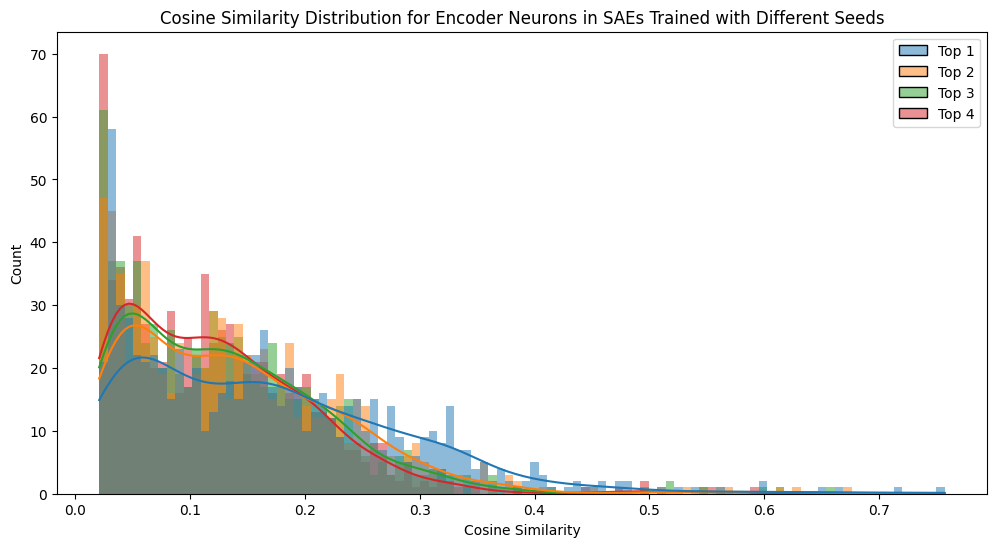

In [156]:
visualize_distribution(enc_neuron_sim_seed, 'Cosine Similarity Distribution for Encoder Neurons in SAEs Trained with Different Seeds', 'Cosine Similarity', 'Count', plot_type='histogram')